In [ ]:
!pip3 install ultralytics
!pip3 install wordcloud
!pip3 install pytesseract
!pip3 install imutils
!pip3 install pillow
!pip3 install keras-ocr
!pip3 install gensim
!pip3 install nltk

In [12]:
from ultralytics import YOLO
from pathlib import Path
from PIL import Image
import torch
import numpy as np
import cv2
import tensorflow as tf
import os
import keras_ocr
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import networkx as nx
from itertools import combinations
import torch.nn as nn
import torch.optim as optim
import json
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Lambda
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import ast

# Demonstration of YOLOv8 inference on a randomly chosen image from the given dataset.

In [ ]:
model = YOLO("yolov8m.pt")

image_folder = Path("./hateful_memes/img/")
image_paths = list(image_folder.glob("*.png"))


0: 640x480 1 person, 1 tie, 281.6ms
Speed: 2.0ms preprocess, 281.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


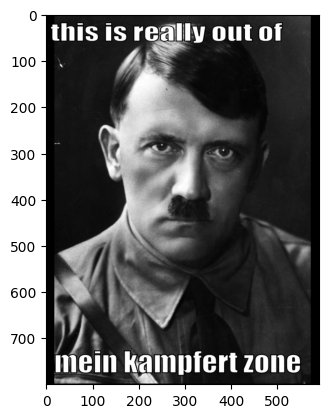

In [3]:
import matplotlib.pyplot as plt
import random

idx = random.randint(0, len(image_paths))

img_1 = Image.open(image_paths[idx])

plt.imshow(img_1)
results = model(img_1)

result = results[0]

Object person detected with probability 0.97
Box coordinates: [19, 59, 572, 791]
Object tie detected with probability 0.29
Box coordinates: [304, 569, 441, 799]


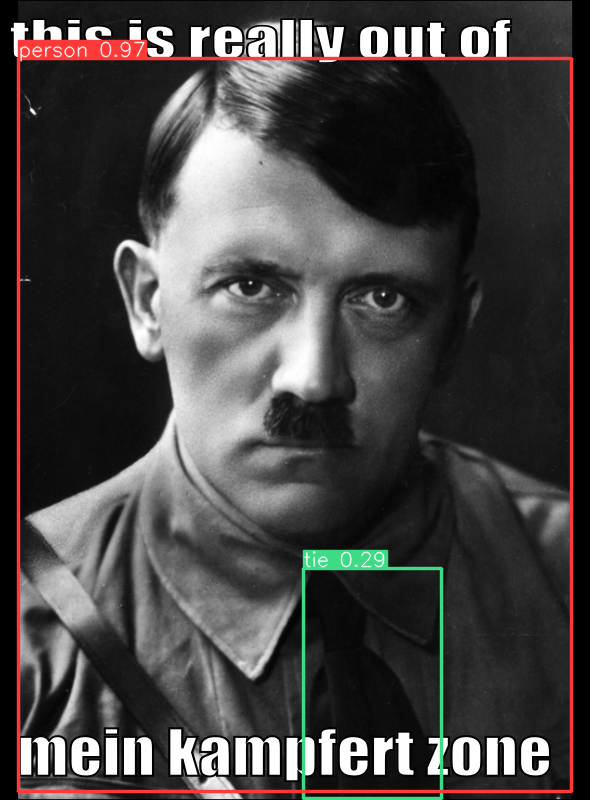

In [4]:
for box in result.boxes:
    label = result.names[box.cls[0].item()]
    coords = [round(x) for x in box.xyxy[0].tolist()]
    probability = round(box.conf[0].item(),2)

    print("Object {} detected with probability {}".format(label, probability))
    print("Box coordinates: {}".format(coords))

Image.fromarray(result.plot()[:, :, ::-1])

In [ ]:
# filtered random 500 images
image_paths_filtered = random.sample(image_paths, 500)

all_objects = []
all_probabilities = []
co_occurrences = []

for image_path in tqdm(image_paths_filtered):
    img = Image.open(image_path)
    results = model(img)
    result = results[0]
    
    objects_in_image = [result.names[box.cls[0].item()] for box in result.boxes]
    probabilities_in_image = [box.conf[0].item() for box in result.boxes]

    co_occurrences.extend(combinations(objects_in_image, 2))
    
    all_objects.extend(objects_in_image)
    all_probabilities.extend(probabilities_in_image)

Summary Statistics:
       Probability
count  1849.000000
mean      0.651189
std       0.238212
min       0.250333
25%       0.417468
50%       0.679300
75%       0.889560
max       0.988203


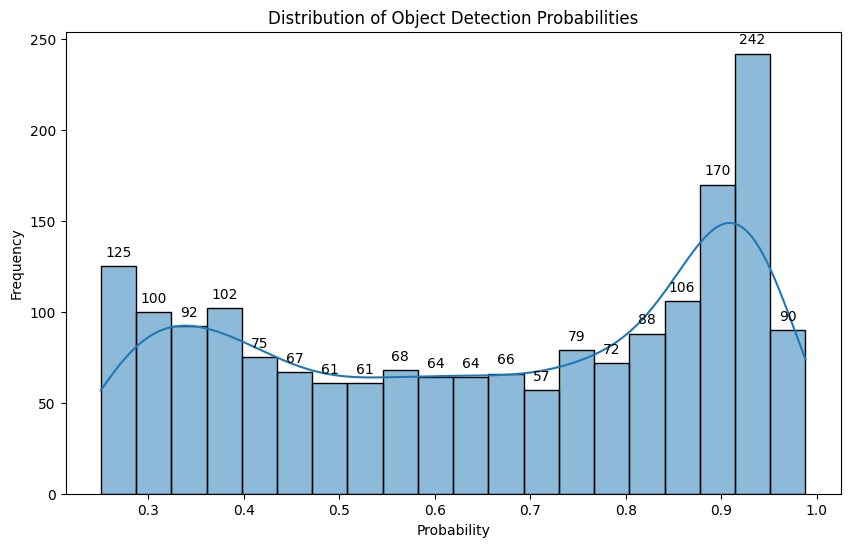

/var/folders/sn/n87ls2012hz6l2qdynmyh12h0000gn/T/ipykernel_672/3478073434.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_objects.values, y=top_objects.index, palette="viridis")


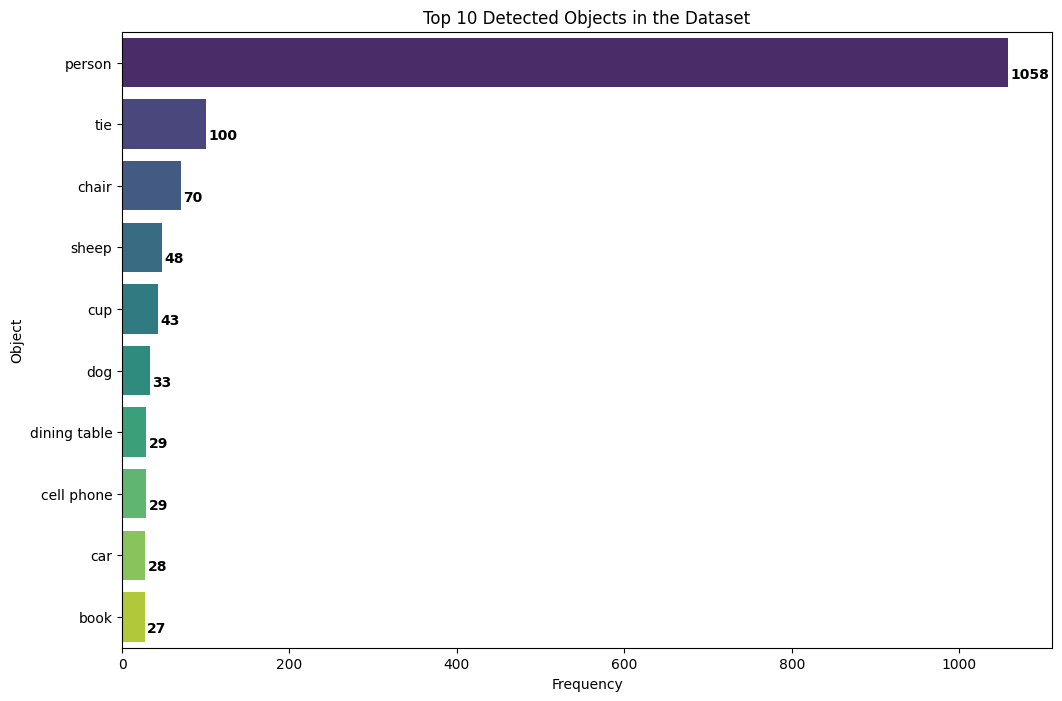

In [6]:
data = pd.DataFrame({'Object': all_objects, 'Probability': all_probabilities})

print("Summary Statistics:")
print(data.describe())

plt.figure(figsize=(10, 6))
sns.histplot(data['Probability'], bins=20, kde=True)
plt.title('Distribution of Object Detection Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')

for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height():.0f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.show()

top_n = 10
top_objects = data['Object'].value_counts().head(top_n)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_objects.values, y=top_objects.index, palette="viridis")
plt.title(f'Top {top_n} Detected Objects in the Dataset')
plt.xlabel('Frequency')
plt.ylabel('Object')

for i, v in enumerate(top_objects.values):
    plt.text(v + 3, i + .25, str(v), color='black', fontweight='bold')
    
plt.show()

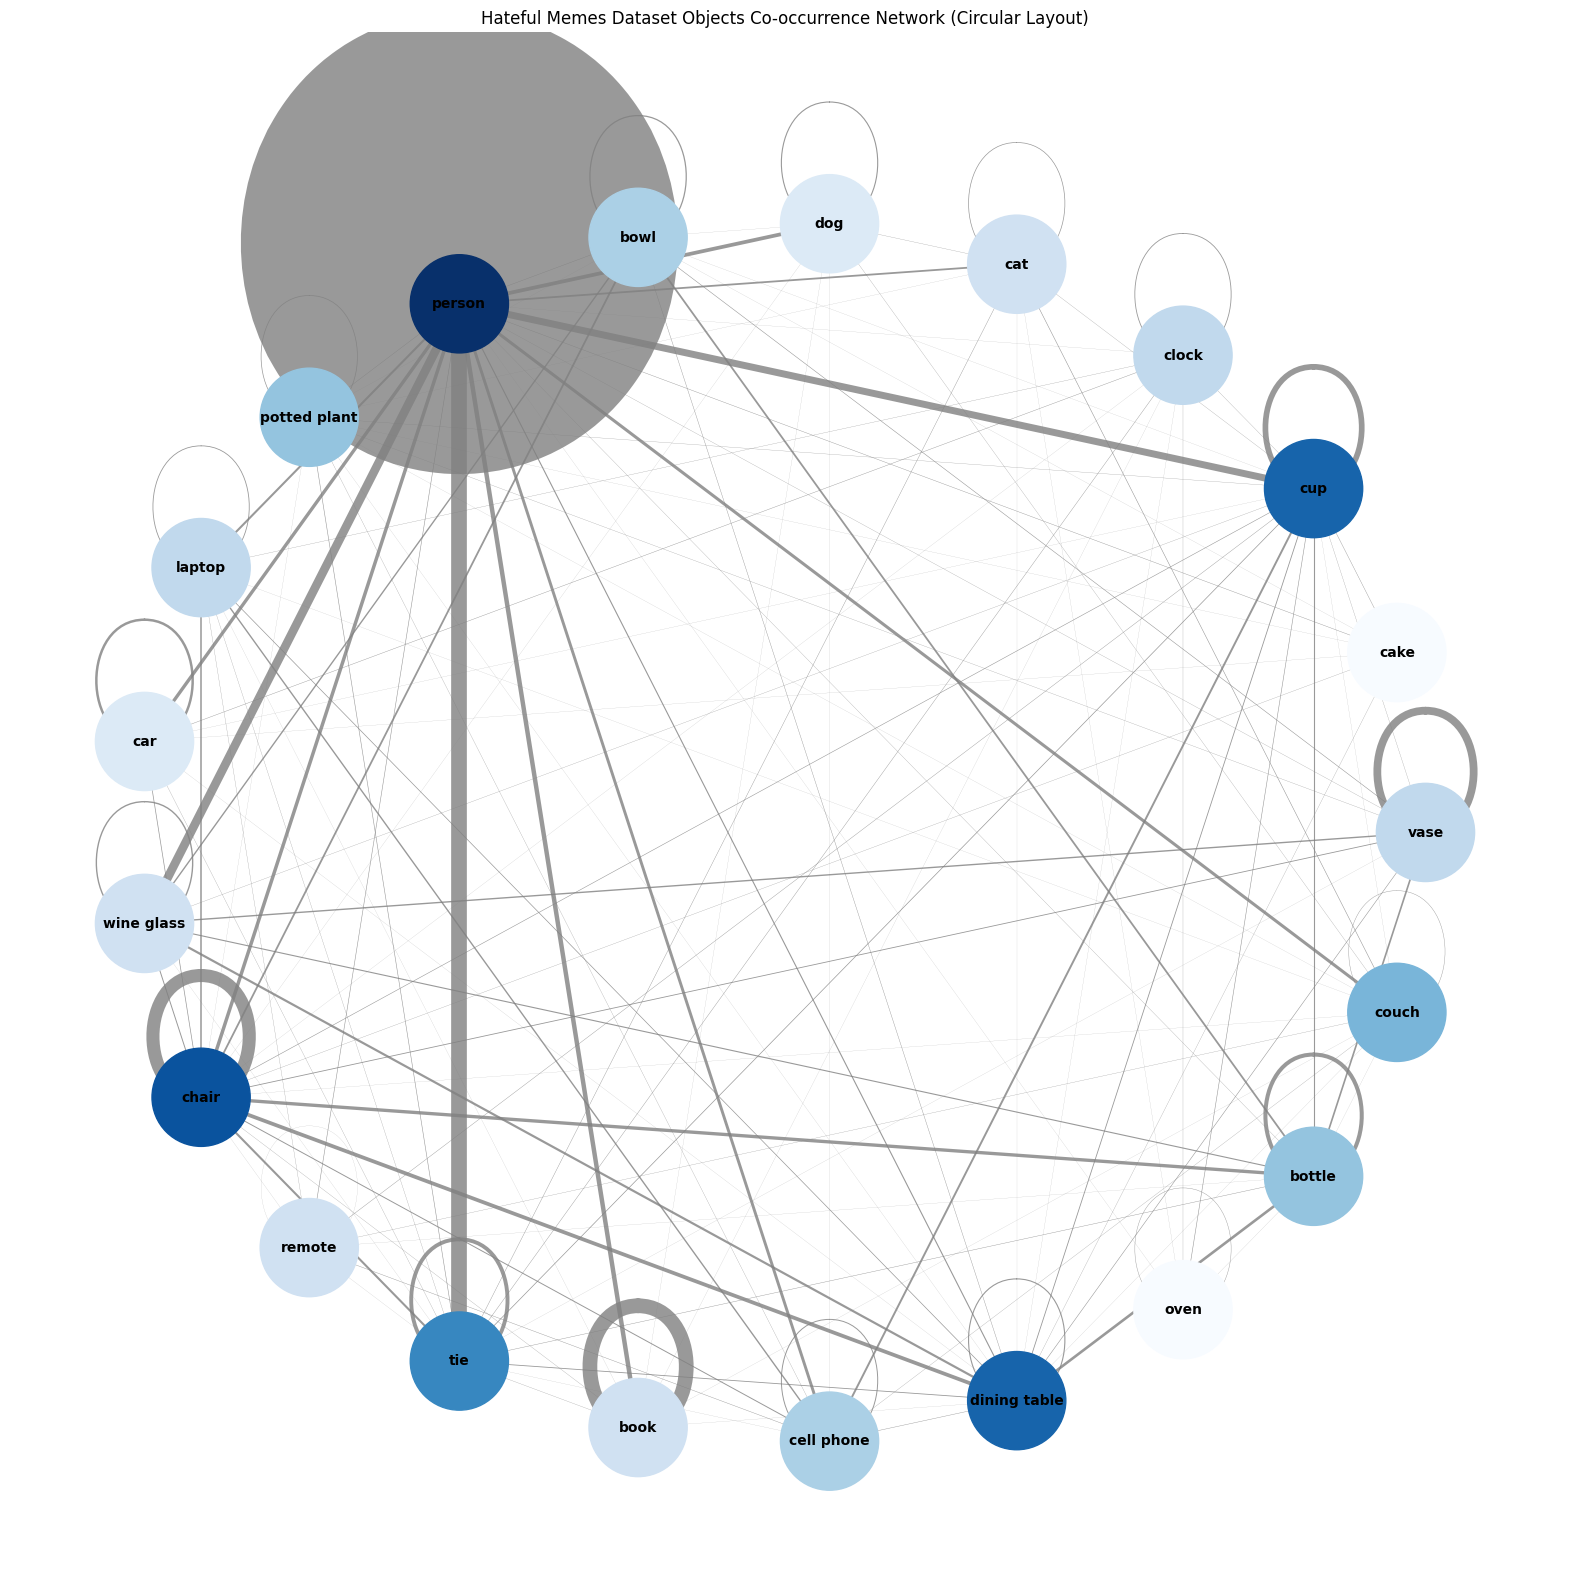

In [7]:
co_occurrence_df = pd.DataFrame(co_occurrences, columns=['Object1', 'Object2'])

co_occurrence_counts = Counter(zip(co_occurrence_df['Object1'], co_occurrence_df['Object2']))

G = nx.Graph()
for (obj1, obj2), weight in co_occurrence_counts.items():
    G.add_edge(obj1, obj2, weight=weight)

min_degree = 10
nodes_to_keep = [node for node, degree in dict(G.degree()).items() if degree >= min_degree]
G = G.subgraph(nodes_to_keep)

pos = nx.circular_layout(G)

node_colors = [G.degree[node] for node in G.nodes]

edge_widths = [0.1 * G[u][v]['weight'] for u, v in G.edges]

plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.Blues, node_size=5000)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='gray', alpha=0.8)
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black', font_weight='bold')
plt.title('Hateful Memes Dataset Objects Co-occurrence Network (Circular Layout)')
plt.axis('off')
plt.show()

# Task-B

In [173]:
def compute_grad(image_gray, mode:str)->np.ndarray:
    dx = cv2.Sobel(image_gray, cv2.CV_64F, 1, 0, ksize=3)
    dy = cv2.Sobel(image_gray, cv2.CV_64F, 0, 1, ksize=3)
    mag = np.sqrt(dx**2 + dy**2)
    return (mag/mag.max()*255).astype(np.uint8)


def detect_draw(pipeline, image_gray, viz):
    img = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2RGB)
    b = pipeline.recognize([img])
    if viz:
        keras_ocr.tools.drawAnnotations(image=img, predictions=b[0])

    bboxes = []
    for i in range(len(b[0])):
        bboxes.append(b[0][i][1])

    return bboxes

def remove(image_gray, bboxes, offset, dilation_factor):
    mask = np.ones_like(image_gray, dtype=np.uint8) * 255

    blur_factor = 7
    inpaint_radius = 4  

    for bbox in bboxes:
        bb = [bbox[0][0], bbox[0][1], bbox[2][0], bbox[2][1]]
        x_min, y_min, x_max, y_max = map(int, bb) # converting to int for ensuring cv2 int type requirement
        cv2.rectangle(mask, (x_min-offset, y_min-offset), (x_max+offset, y_max+offset), (0,0,0), -1)


    # ********************************************************************************************** #
    
    # Option 1: Apply inpainting to the masked regions
        
    mask = cv2.bitwise_not(mask) # inverting the mask to inpaint the masked regions

    # plt.imshow(mask, cmap='gray')
    # plt.show()

    inpainted_image = cv2.inpaint(image_gray.copy(), mask, inpaint_radius, cv2.INPAINT_NS)
    return inpainted_image

    # ********************************************************************************************** #

    # Option 2: Apply Gaussian blur only to the masked regions
        
    # kernel = np.ones((dilation_factor, dilation_factor), np.uint8)
    # dilated_mask = cv2.dilate(mask, kernel, iterations=1)
    # blurred_masked_image = image_gray.copy()
    # blurred_masked_image[dilated_mask == 0] = cv2.GaussianBlur(image_gray, (blur_factor, blur_factor), 0)[dilated_mask == 0]
    # return blurred_masked_image

    # ********************************************************************************************** #
    
    # Option 3: Apply naive bitwise AND operation for masking

    # masked_image = cv2.bitwise_and(image_gray, dilated_mask)
    # return masked_image

    # ********************************************************************************************** #

In [174]:
def main(pipeline, image_gray, offset):
    mag = compute_grad(image_gray,"single")
    bboxes = detect_draw(pipeline, mag, viz=True)
    masked_image = remove(image_gray, bboxes, offset=10, dilation_factor=10)
    return masked_image

pipeline = keras_ocr.pipeline.Pipeline()

Looking for /Users/swayam/.keras-ocr/craft_mlt_25k.h5
Looking for /Users/swayam/.keras-ocr/crnn_kurapan.h5


1/1 [==============================] - 2s 2s/step


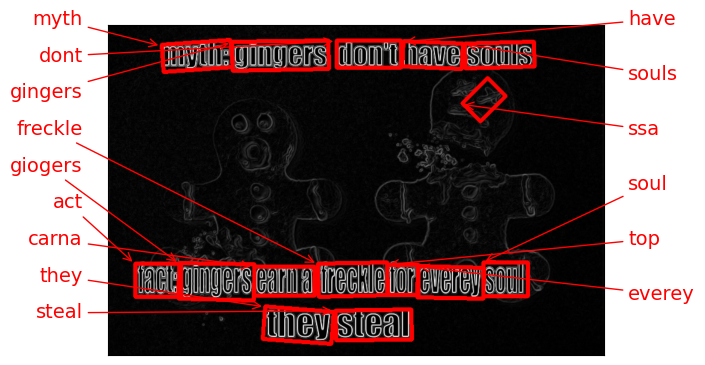

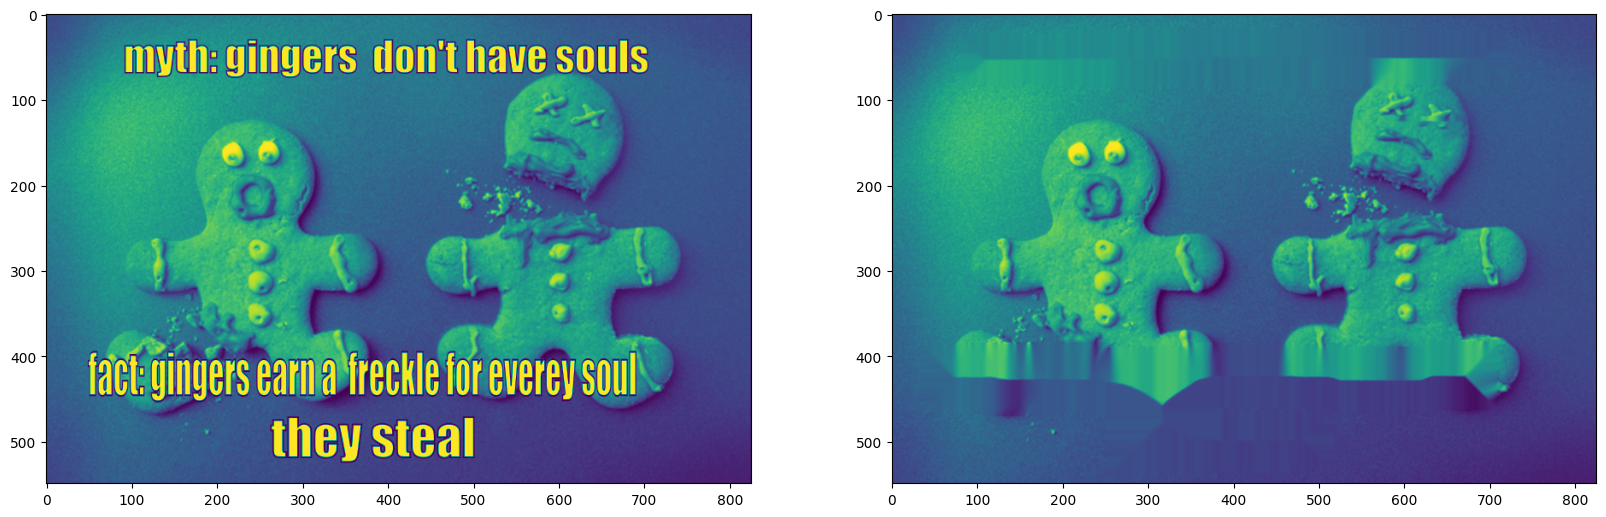

In [200]:
image = cv2.imread(str(image_paths[7470]))
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

masked_image = main(pipeline,image_gray,0)
fig, ax = plt.subplots(1,2,figsize=(20,7))

ax[0].imshow(image_gray)
ax[1].imshow(masked_image)


0: 448x640 3 donuts, 1 cake, 275.2ms
Speed: 6.4ms preprocess, 275.2ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)
Object donut detected with probability 0.96
Box coordinates: [444, 231, 744, 466]
Object donut detected with probability 0.85
Box coordinates: [73, 123, 391, 466]
Object donut detected with probability 0.76
Box coordinates: [535, 69, 677, 218]
Object cake detected with probability 0.52
Box coordinates: [7, 3, 795, 545]


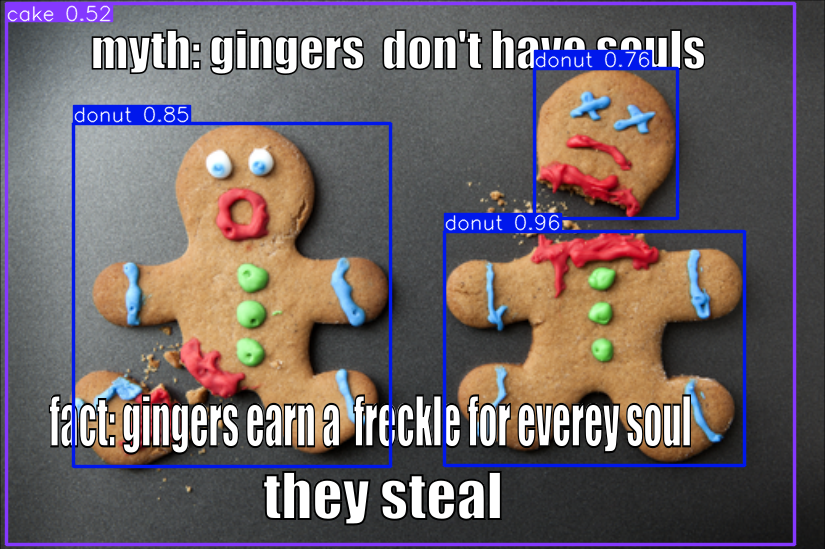

In [201]:
results = model(image)
result = results[0]

for box in result.boxes:
    label = result.names[box.cls[0].item()]
    coords = [round(x) for x in box.xyxy[0].tolist()]
    probability = round(box.conf[0].item(),2)

    print("Object {} detected with probability {}".format(label, probability))
    print("Box coordinates: {}".format(coords))

Image.fromarray(result.plot()[:, :, ::-1])


0: 448x640 2 donuts, 220.6ms
Speed: 2.2ms preprocess, 220.6ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)
Object donut detected with probability 0.69
Box coordinates: [443, 231, 744, 454]
Object donut detected with probability 0.49
Box coordinates: [535, 80, 677, 218]


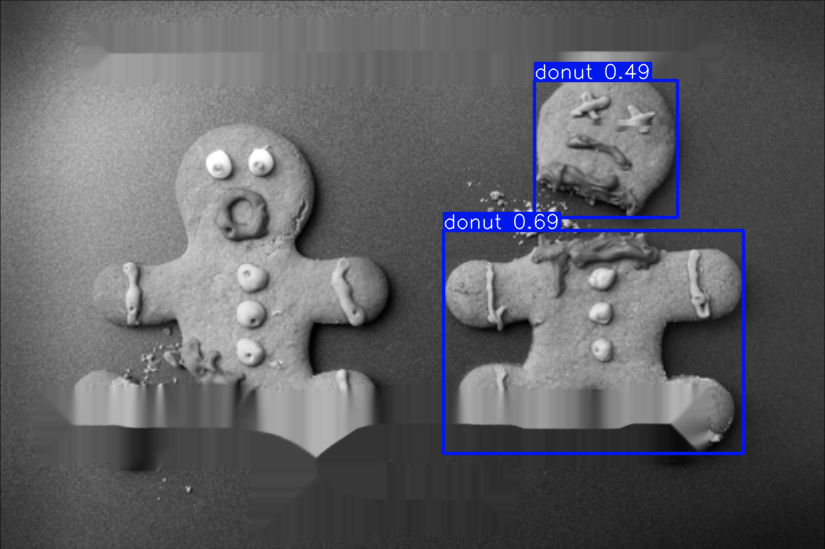

In [202]:
masked_image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_GRAY2RGB)
masked_image_rgb = np.array(masked_image_rgb)
masked_image_rgb = np.expand_dims(masked_image_rgb, axis=0)

masked_image_rgb = masked_image_rgb.reshape(image.shape)

results = model(masked_image_rgb)
result = results[0]

for box in result.boxes:
    label = result.names[box.cls[0].item()]
    coords = [round(x) for x in box.xyxy[0].tolist()]
    probability = round(box.conf[0].item(),2)

    print("Object {} detected with probability {}".format(label, probability))
    print("Box coordinates: {}".format(coords))

Image.fromarray(result.plot()[:, :, ::-1])

# Task C

In [8]:
class HatefulMemesDataset(Dataset):
    def __init__(self, json_path, img_folder, transform=None):
        self.data = []
        with open(json_path, 'r') as f:
            for line in f:
                sample = json.loads(line)
                self.data.append(sample)
        self.img_folder = Path(img_folder)  # Convert img_folder to a Path object
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]['img']
        img = Image.open(self.img_folder / img_path)

        label = torch.tensor(self.data[idx]['label'], dtype=torch.float32)
        text = self.data[idx]['text']

        if self.transform:
            img = self.transform(img)

        return {'image': img, 'label': label, 'text': text}

transform = transforms.Compose([
    Lambda(lambda x: x.convert('RGB')),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = HatefulMemesDataset(json_path='./hateful_memes/train.jsonl', img_folder='./hateful_memes', transform=transform)
test_dataset = HatefulMemesDataset(json_path='./hateful_memes/test_unseen.jsonl', img_folder='./hateful_memes', transform=transform)

new_train_dataset = torch.utils.data.Subset(train_dataset, torch.randperm(len(train_dataset))[:int(len(train_dataset)*0.1)])
new_train_loader = DataLoader(new_train_dataset, batch_size=32, shuffle=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
shapes = set()
for batch in new_train_loader:
    shapes.add(tuple(batch['image'].shape[1:]))
print(shapes)

test_shapes = set()
for batch in test_loader:
    test_shapes.add(tuple(batch['image'].shape[1:]))
print(test_shapes)

In [13]:
class ImageClassifier(nn.Module):
    def __init__(self, hidden_size=256):
        super(ImageClassifier, self).__init__()

        self.image_features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * 56 * 56, hidden_size), nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 128), nn.ReLU(),
            nn.Linear(128, 1), nn.Sigmoid()
        )

    def forward(self, image):
        image_features = self.image_features(image)
        output = self.fc(image_features)
        return output

In [14]:
model = ImageClassifier(hidden_size=256)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    for batch in tqdm(new_train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        image = batch['image']
        label = batch['label']

        output = model(image)
        loss = criterion(output, label.unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

Epoch 1/2: 100%|██████████| 27/27 [01:32<00:00,  3.43s/it]


Epoch [1/2], Loss: 0.6036145687103271


Epoch 2/2: 100%|██████████| 27/27 [01:40<00:00,  3.73s/it]

Epoch [2/2], Loss: 0.7626084685325623


In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    for batch in test_loader:
        image = batch['image']
        label = batch['label']
        output = model(image)
        predicted = (output > 0.5).float()
        all_predictions.extend(predicted)
        all_labels.extend(label)
        correct += (predicted == label.unsqueeze(1)).sum().item()
        total += label.size(0)

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

print(classification_report(all_labels, all_predictions))

cm = confusion_matrix(all_labels, all_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classfication of memes as hatefull or non-hateful on basis of the text in the meme.

In [40]:
class HatefulMemesDatasetText(Dataset):
    def __init__(self, json_path, img_folder, text_embeddings_path, transform=None):
        self.data = []
        with open(json_path, 'r') as f:
            for line in f:
                sample = json.loads(line)
                self.data.append(sample)

        self.text_embeddings = pd.read_csv(text_embeddings_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = torch.tensor(self.data[idx]['label'], dtype=torch.float32)
        text_id = int(self.data[idx]['id'])
        vectorized_text_str = self.text_embeddings.loc[self.text_embeddings['id'] == text_id, 'vectorized_text'].values[0]
        vectorized_text_list = [float(value) for value in vectorized_text_str[1:-1].split()]  
        vectorized_text = torch.tensor(vectorized_text_list, dtype=torch.float32)
        return {'label': label, 'vectorized_text': vectorized_text}

text_embeddings_path = './Text-Embeddings.csv'
text_embeddings_path_test = './Text-Embeddings_test.csv'

train_dataset = HatefulMemesDatasetText(json_path='./hateful_memes/train.jsonl', img_folder='./hateful_memes', text_embeddings_path=text_embeddings_path, transform=transform)
test_dataset = HatefulMemesDatasetText(json_path='./hateful_memes/test_seen.jsonl', img_folder='./hateful_memes', text_embeddings_path=text_embeddings_path_test, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

new_train_dataset = torch.utils.data.Subset(train_dataset, torch.randperm(len(train_dataset))[:int(len(train_dataset)*0.1)])
new_train_loader = DataLoader(new_train_dataset, batch_size=32, shuffle=True)

In [48]:
class TextOnlyClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=512):
        super(TextOnlyClassifier, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, vectorized_text):
        output = self.fc(vectorized_text)
        return output

input_size = len(train_dataset[0]['vectorized_text'])
model = TextOnlyClassifier(input_size=input_size, hidden_size=512)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0008)

num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        vectorized_text = batch['vectorized_text']
        label = batch['label']
        output = model(vectorized_text)
        loss = criterion(output, label.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

model.eval()

with torch.no_grad():
    predictions = []
    true_labels = []
    for batch in test_loader:
        vectorized_text = batch['vectorized_text']
        label = batch['label']
        output = model(vectorized_text)
        predicted = (output > 0.5).float()

        predictions.extend(predicted.squeeze().tolist())
        true_labels.extend(label.tolist())

accuracy = accuracy_score(true_labels, predictions)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Epoch 1/15: 100%|██████████| 266/266 [00:02<00:00, 109.48it/s]


Epoch [1/15], Loss: 0.5702252388000488


Epoch 2/15: 100%|██████████| 266/266 [00:02<00:00, 120.13it/s]


Epoch [2/15], Loss: 0.5421139001846313


Epoch 3/15: 100%|██████████| 266/266 [00:02<00:00, 118.30it/s]


Epoch [3/15], Loss: 0.6391540765762329


Epoch 4/15: 100%|██████████| 266/266 [00:02<00:00, 119.42it/s]


Epoch [4/15], Loss: 0.5074430704116821


Epoch 5/15: 100%|██████████| 266/266 [00:02<00:00, 117.78it/s]


Epoch [5/15], Loss: 0.6048722863197327


Epoch 6/15: 100%|██████████| 266/266 [00:02<00:00, 116.92it/s]


Epoch [6/15], Loss: 0.7366359829902649


Epoch 7/15: 100%|██████████| 266/266 [00:02<00:00, 113.93it/s]


Epoch [7/15], Loss: 0.48801389336586


Epoch 8/15: 100%|██████████| 266/266 [00:02<00:00, 115.40it/s]


Epoch [8/15], Loss: 0.5350703001022339


Epoch 9/15: 100%|██████████| 266/266 [00:02<00:00, 116.96it/s]


Epoch [9/15], Loss: 0.44856834411621094


Epoch 10/15: 100%|██████████| 266/266 [00:02<00:00, 120.05it/s]


Epoch [10/15], Loss: 0.5735100507736206


Epoch 11/15: 100%|██████████| 266/266 [00:02<00:00, 117.78it/s]


Epoch [11/15], Loss: 0.567919135093689


Epoch 12/15: 100%|██████████| 266/266 [00:02<00:00, 119.28it/s]


Epoch [12/15], Loss: 0.45071300864219666


Epoch 13/15: 100%|██████████| 266/266 [00:02<00:00, 118.64it/s]


Epoch [13/15], Loss: 0.5522339940071106


Epoch 14/15: 100%|██████████| 266/266 [00:02<00:00, 119.94it/s]


Epoch [14/15], Loss: 0.28955134749412537


Epoch 15/15: 100%|██████████| 266/266 [00:02<00:00, 111.76it/s]


Epoch [15/15], Loss: 0.234847754240036
Test Accuracy: 58.70%
